This notebook demonstrates using QISKit ACQUA Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances with different fermionic mappings to quantum qubits.

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the qiskit_acqua_chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

In [1]:
import paths
import numpy as np
import pylab
from qiskit_acqua_chemistry import QISChem

# Input dictionary to configure qischem for the chemistry problem.
qischem_dict = {
    'problem': {'random_seed': 50},
    'driver': {'name': 'PYSCF'},
    'PYSCF': {'atom': '', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'qubit_mapping': '', 'two_qubit_reduction': False},
    'algorithm': {'name': ''},
    'optimizer': {'name': 'L_BFGS_B', 'maxfun': 2500},
    'variational_form': {'name': 'RYRZ', 'depth': 5}
}
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'

algorithms = ['VQE', 'ExactEigensolver']
mappings   = ['jordan_wigner', 'parity', 'bravyi_kitaev']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies  = np.empty([len(mappings), len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    qischem_dict['PYSCF']['atom'] = molecule.format(d/2) 
    for j in range(len(algorithms)):
        qischem_dict['algorithm']['name'] = algorithms[j] 
        for k in range(len(mappings)):
            qischem_dict['operator']['qubit_mapping'] = mappings[k] 
            solver = QISChem()
            result = solver.run(qischem_dict)
            energies[k][j][i] = result['energy']
            hf_energies[i] = result['hf_energy']  # Independent of algorithm & mapping
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)


Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[[-1.05500766 -1.07447033 -1.09248387 -1.10560816 -1.11617546
   -1.12409152 -1.12989776 -1.13377936 -1.13618819 -1.13718162
   -1.13693673 -1.11393966 -1.13367441 -1.10702424 -1.10251097
   -1.09745431 -1.11829213 -1.08595587 -1.09072927 -1.10588241
   -1.10113192]
  [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601
   -1.12416092 -1.12990478 -1.13382622 -1.13618945 -1.13722138
   -1.13711707 -1.13604436 -1.13414767 -1.13155121 -1.12836188
   -1.12467175 -1.12056028 -1.11609624 -1.11133942 -1.10634211
   -1.10115033]]

 [[-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601
   -1.12416092 -1.12990478 -1.13382621 -1.13618943 -1.1372106
   -1.13710687 -1.13602076 -1.13411645 -1.13151736 -1.12831802
   -1.12463919 -1.12051877 -1.11605103 -1.11130219 -1.10631675
   -1.10113064]
  [-1.055159

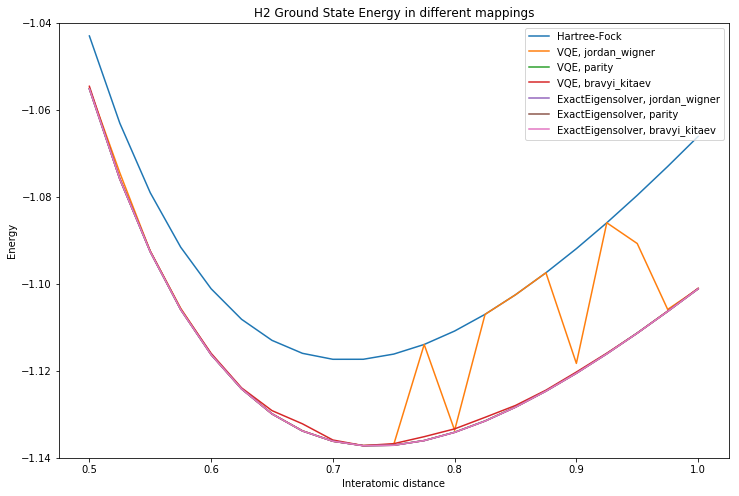

In [2]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.ylim(-1.14, -1.04)
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    for k in range(len(mappings)):
        pylab.plot(distances, energies[k][j], label=algorithms[j] + ", " + mappings[k])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy in different mappings')
pylab.legend(loc='upper right')
pylab.show()

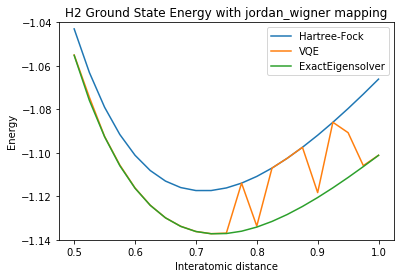

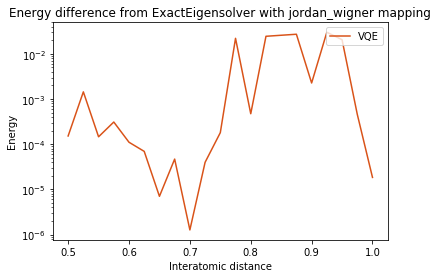

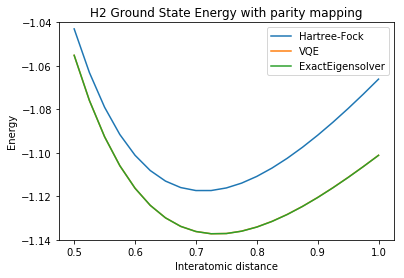

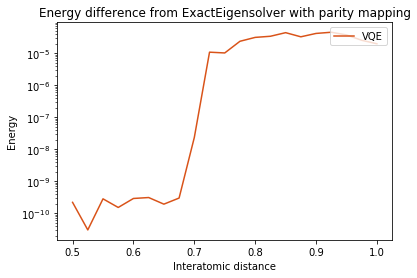

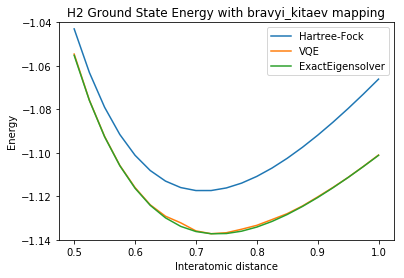

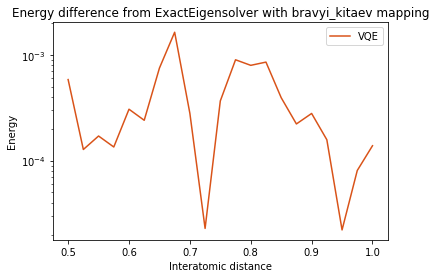

In [3]:
pylab.rcParams['figure.figsize'] = (6, 4)
for k in range(len(mappings)):
    pylab.ylim(-1.14, -1.04)
    pylab.plot(distances, hf_energies, label='Hartree-Fock')
    for j in range(len(algorithms)):
        pylab.plot(distances, energies[k][j], label=algorithms[j])
    pylab.xlabel('Interatomic distance')
    pylab.ylabel('Energy')
    pylab.title('H2 Ground State Energy with {} mapping'.format(mappings[k]))
    pylab.legend(loc='upper right')
    pylab.show()
    
    #pylab.plot(distances, np.subtract(hf_energies, energies[k][1]), label='Hartree-Fock')
    pylab.plot(distances, np.subtract(energies[k][0], energies[k][1]), color=[0.8500, 0.3250, 0.0980], label='VQE')
    pylab.xlabel('Interatomic distance')
    pylab.ylabel('Energy')
    pylab.yscale('log')
    pylab.title('Energy difference from ExactEigensolver with {} mapping'.format(mappings[k]))
    pylab.legend(loc='upper right')
    pylab.show()